# Path Tracing Notebook
The first 5 code cells are required only on Google Colab. Ignore them if you are running the notebook from your local machine.

In [ ]:
# 1. Run only if you need to delete cached folder from Google Colab
!rm -rf /content/light-transport

In [ ]:
# 2. Download the project files from Github
!git clone https://github.com/dipanjan92/light-transport.git

In [ ]:
# 3. Add the project directory to the system PATH
import sys
sys.path.insert(0,'/content/light-transport/LightTransportSimulator')

In [ ]:
# 4. PyVista is used to generate 3D objects
!pip install pyvista

In [1]:
# 5. Switch to project directory
import os
os.chdir('/content/light-transport/')
os.getcwd()

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/light-transport/'

********************************************************************************************

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import numba

In [2]:
from LightTransportSimulator.light_transport.src.primitives import Sphere
from LightTransportSimulator.light_transport.src.cornell_box import get_cornell_sphere_box, get_cornell_box
from LightTransportSimulator.light_transport.src.constants import *
from LightTransportSimulator.light_transport.src.material import Material
from LightTransportSimulator.light_transport.src.vectors import normalize

In [3]:
WHITE_COLOR = Color(ambient=np.array([1, 1, 1], dtype=np.float64),
                    diffuse=np.array([1, 1, 1], dtype=np.float64),
                    specular=np.array([1, 1, 1], dtype=np.float64))

NO_COLOR = Color(ambient=np.array([0, 0, 0], dtype=np.float64),
                 diffuse=np.array([0, 0, 0], dtype=np.float64),
                 specular=np.array([0, 0, 0], dtype=np.float64))


RED_COLOR = Color(ambient=np.array([.75, .25, .25], dtype=np.float64),
                  diffuse=np.array([.75, .25, .25], dtype=np.float64),
                  specular=np.array([.75, .25, .25], dtype=np.float64))

GREEN_COLOR = Color(ambient=np.array([.25, .75, .25], dtype=np.float64),
                  diffuse=np.array([.25, .75, .25], dtype=np.float64),
                  specular=np.array([.25, .75, .25], dtype=np.float64))

BLUE_COLOR = Color(ambient=np.array([.25, .25, .75], dtype=np.float64),
                   diffuse=np.array([.25, .25, .75], dtype=np.float64),
                   specular=np.array([.25, .25, .75], dtype=np.float64))

GRAY_COLOR = Color(ambient=np.array([.75, .75, .75], dtype=np.float64),
                   diffuse=np.array([.75, .75, .75], dtype=np.float64),
                   specular=np.array([.75, .75, .75], dtype=np.float64))

GRAY_COLOR2 = Color(ambient=np.array([.25, .25, .25], dtype=np.float64),
                   diffuse=np.array([.25, .25, .25], dtype=np.float64),
                   specular=np.array([.25, .25, .25], dtype=np.float64))

GLASS_COLOR = Color(ambient=np.array([.999, .999, .999], dtype=np.float64),
                    diffuse=np.array([.999, .999, .999], dtype=np.float64),
                    specular=np.array([.999, .999, .999], dtype=np.float64))

In [4]:
from LightTransportSimulator.light_transport.src.scene import Light
from LightTransportSimulator.light_transport.src.light_samples import generate_area_light_samples

# # Create a global light source

source_mat = Material(color=WHITE_COLOR, shininess=1, ior=1.5, type=MatType.NONE.value, emission=12)
light_sphere = Sphere(center=np.array([50, 681.6-.27, 81.6], dtype=np.float64), radius=600, material=source_mat)

# Light source within Cornell Box is a spherical cap

# hypotenuse = radius of the light sphere, light_disk_radius = radius of the base of the cap
# https://mathworld.wolfram.com/SphericalCap.html
cornell_box_top_y = 81.6

_h = cornell_box_top_y - (light_sphere.center[1] - light_sphere.radius) # height of sphere cap

light_disk_radius = np.sqrt(_h*(2*light_sphere.radius-_h))

light_area = 2 * np.pi * light_sphere.radius * _h

light_disk_center = np.array([50, cornell_box_top_y-_h, 81.6], dtype=np.float64)

light_normal = normalize(light_disk_center - light_sphere.center)

light_samples_n = 100

lights = numba.typed.List()

for i in range(light_samples_n):
    _l = Light(light_sphere.center, light_disk_radius, light_sphere.material, light_normal, light_area)
    lights.append(_l)

_h, light_disk_center, light_disk_radius

(0.2699999999999534, array([50.  , 81.33, 81.6 ]), 17.99797488607938)

In [5]:
lights[0].source

array([ 50.  , 681.33,  81.6 ])

In [6]:
from LightTransportSimulator.light_transport.src.scene import Camera, SphereScene

# Setup scene

# point camera
camera_pos = np.array([50, 52, 295.6], dtype=np.float64)
camera = Camera(camera_pos)

# screen 16:9
width=256
height=192
width = 1024
height = 768

# max_depth is the conventional term used in rendering to denote
# the maximum number of times a ray can bounce within the scene
max_depth=7
# number of samples per pixel
n_samples = 16

# Initialise the scene with lights and camera
scene = SphereScene(camera=camera, lights=lights, width=width, height=height, max_depth=max_depth, f_distance=1, number_of_samples=n_samples//4)

In [7]:
# update the transformation matrix
# It's updated outside __init__ as numba giving compile time errors

# T = scene.t_matrix
# T[:3, 3] = camera.position
# T[:3, :3] = np.linalg.inv(np.array([normalize(np.cross(camera.look_at, camera.scene_normal)), camera.look_at, normalize(np.cross(camera.look_at, normalize(np.cross(camera.look_at, camera.scene_normal))))]))

T = np.array([
    [1, 0, 0, 50],
    [0, 1, 0, 40.8],
    [0, 0, 1, 81.6],
    [0, 0, 0, 1]
], dtype=np.float64)

scene.t_matrix = T
scene.t_matrix

array([[ 1. ,  0. ,  0. , 50. ],
       [ 0. ,  1. ,  0. , 40.8],
       [ 0. ,  0. ,  1. , 81.6],
       [ 0. ,  0. ,  0. ,  1. ]])

In [8]:
# Set wall colors and materials for the Cornell box

surface_mat = Material(color=BLUE_COLOR, shininess=30, ior=1.5210, type=MatType.DIFFUSE.value, emission=0)
left_wall_mat = Material(color=RED_COLOR, shininess=30, ior=1.5210, type=MatType.DIFFUSE.value, emission=0)
right_wall_mat = Material(color=RED_COLOR, shininess=30, ior=1.5210, type=MatType.DIFFUSE.value, emission=0)
front_wall_mat = Material(color=BLUE_COLOR, shininess=30, ior=1.5210, type=MatType.DIFFUSE.value, emission=0)

# Get the triangles required to render the Cornell box
spheres = get_cornell_sphere_box(scene, surface_mat, left_wall_mat, right_wall_mat, front_wall_mat)

In [9]:
spheres.append(light_sphere)

In [10]:
# Add the triangles in the list of objects
PLASTIC = Material(color=GREEN_COLOR, shininess=10, ior=1.460, type=MatType.SPECULAR.value, emission=0)
GLASS = Material(color=GLASS_COLOR, shininess=50, ior=1.500, type=MatType.SPECULAR.value, emission=0)
MIRROR = Material(color=GLASS_COLOR, shininess=50, ior=1.500, type=MatType.MIRROR.value, emission=0)
ALUMINUM = Material(color=GRAY_COLOR2, shininess=50, ior=1.400, type=MatType.SPECULAR.value, emission=0)

In [11]:
sphere_1 = Sphere(center=np.array([27, 16.5, 47], dtype=np.float64), radius=16.5, material=MIRROR)
spheres.append(sphere_1)
sphere_2 = Sphere(center=np.array([73, 16.5, 78], dtype=np.float64), radius=16.5, material=GLASS)
spheres.append(sphere_2)
# sphere_3 = Sphere(center=np.array([-0.3, 0, 0, 1], dtype=np.float64), radius=0.15, material=GLASS)
# objects.append(sphere_3)

In [12]:
triangles = numba.typed.List()

In [13]:
from LightTransportSimulator.light_transport.src.bvh_new import BoundedBox, BVHNode, build_bvh, LinearBVHNode, flatten_bvh, intersect_bvh

# Enclose all the primitives in their individual axis-aligned bounding boxes (AABB)
bounded_boxes = []
for i in range(len(triangles)):
    bounded_boxes.append(BoundedBox(triangles[i], i))

len(triangles), len(bounded_boxes)

(0, 0)

In [14]:
if len(triangles)>0:
    # Initialise a bounding volume hierarchy tree
    start = 0
    end = len(bounded_boxes)
    ordered_prims = []
    total_nodes = 0
    root, bounded_boxes, ordered_prims, total_nodes = build_bvh(triangles, bounded_boxes, start, end, ordered_prims, total_nodes)
    # swap the primitives array with the ordered list
    primitives = ordered_prims


    # create a linear representation of the bvh tree
    linear_nodes = numba.typed.List()
    for _ in range(total_nodes):
        linear_nodes.append(LinearBVHNode())


    # linear bvh
    linear_bvh, off_set = flatten_bvh(linear_nodes, root, 0)
    # len(linear_bvh)

    # check if indexes of all primitives present in the linear bvh tree
    total = 0
    for _bvh in linear_bvh:
        total+= _bvh.n_primitives
    print(total==len(triangles)) # should be equal to the number of primitives
else:
    linear_bvh = None
    triangles = None

In [15]:
from LightTransportSimulator.light_transport.src.global_illumination import render_scene
# from LightTransportSimulator.light_transport.src.render_old import render_scene

start = time.time()
# primitives = spheres, triangles
image = render_scene(scene, spheres, triangles, linear_bvh)
image = np.flipud(image) # flipped
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\global_illumination.py:144: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  color = color + trace_path(scene, spheres, triangles, bvh, cam_ray, 0)
C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\global_illumination.py:144: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  color = color + trace_path(scene, spheres, triangles, bvh, cam_ray, 0)
C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\global_illumination.py:144: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  color = color + trace_path(scene, spheres, triangles, bvh, cam_ray, 0)


0.012.51629726205997425.03259452411994750.06518904823989437.5488917861799262.5814863102998775.09778357235984

87.61408083441982





25.16297262059974
37.67926988265971
75.22816166883963
87.74445893089961
12.646675358539765
62.71186440677966
50.19556714471969
0.1303780964797914
25.29335071707953
37.809647979139505
75.35853976531942
87.8748370273794
12.777053455019557
0.2607561929595828
62.84224250325945
50.32594524119948
37.94002607561929
25.423728813559322
75.48891786179922
88.00521512385919
12.907431551499348
0.39113428943937417
50.45632333767927
62.972620599739244
38.07040417209909
25.554106910039113
75.61929595827901
88.13559322033899
13.03780964797914
0.5215123859191656
50.58670143415906
63.10299869621903
38.20078226857888
25.684485006518905
75.7496740547588
88.26597131681878
13.168187744458931
38.33116036505867
25.814863102998697
50.717079530638856
0.651890482398957
63.23337679269883
75.88005215123859
88.39634941329857
13.298565840938723
38.46153846153846
25.945241199478488
0.782

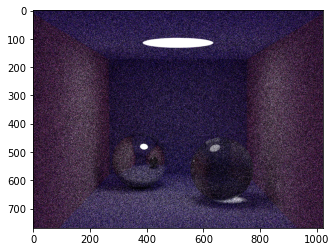

In [16]:
plt.imshow(image)

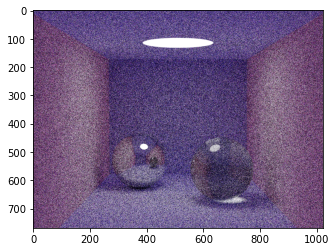

In [17]:
# gamma correction
img_corrected = np.clip(255.0 * np.power(image, 1.0 / 2.2), a_min=0.0, a_max=255.0).astype(int)
plt.imshow(img_corrected)